In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.neural_network import MLPRegressor
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# from math import pi
# from bokeh.plotting import figure, show, output_notebook
# from nsepy.archives import get_price_history

In [2]:
# %matplotlib notebook
%matplotlib inline

In [3]:
toll = pd.read_csv('time_between_two_tolls_new.csv')

In [4]:
toll['ist_timestamp'] = toll['ist_timestamp'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
toll['loading_out_time'] = toll['loading_out_time'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') )
toll['hours']  = toll['ist_timestamp'] - toll['loading_out_time']
toll['hours'] = toll.hours.apply(lambda x:x.total_seconds()/3600)

In [5]:
toll['distance_travelled'] = 0.0
toll['time_taken'] = toll['hours']
toll['time_btn_tolls'] = 0

In [9]:
new_time = pd.DataFrame(columns=toll.columns.tolist())

In [10]:
for truck in toll.vehicle_no.unique().tolist():
    for st_time in toll.start_date.unique().tolist():
        df = toll[(toll.vehicle_no == truck) & (toll.start_date == st_time)].sort_values('odometer_km')
        df.distance_travelled = df.odometer_km.diff()
        df.time_btn_tolls = df.hours.diff()
        new_time = new_time.append(df)


In [11]:
new_time = new_time.loc[new_time['distance_travelled'] != 0]
new_time = new_time.fillna(0)

In [12]:
new_time['distance_travelled_cummulative'] = 0

for truck in new_time.vehicle_no.unique().tolist():
    for st_time in new_time.start_date.unique().tolist():
        new_time.loc[(new_time['vehicle_no'] == truck) & (new_time['start_date'] == st_time), 'distance_travelled_cummulative'] = new_time.loc[(new_time['vehicle_no'] == truck) & (new_time['start_date'] == st_time)]['distance_travelled'].cumsum()



In [13]:
new_time.loc[new_time['time_btn_tolls'] == 0, 'time_btn_tolls']  = new_time.loc[new_time['time_btn_tolls'] == 0, 'time_taken']  

In [14]:
new_time['delivery_status'] = 0
new_time['start_date'] = new_time['start_date'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') )
new_time['eta'] = toll['eta'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') )
new_time['unloading_in_time'] = new_time['unloading_in_time'].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') )

In [15]:
new_time['delivery_status'] = (new_time['unloading_in_time'] - new_time['loading_out_time']) - (new_time['eta'] - new_time['start_date'])

In [16]:
new_time['delivery_status'] = new_time['delivery_status'].apply(lambda x: x.total_seconds()/3600)
                                

In [17]:
new_time['delivery'] = ''
new_time.loc[new_time['delivery_status'] > 24, 'delivery'] = 'delay'
new_time.loc[(new_time['delivery_status'] <= 24) & (new_time['delivery_status'] >= 0), 'delivery'] = 'on-time'
new_time.loc[(new_time['delivery_status'] < 0), 'delivery'] = 'early'

In [18]:
new_time.delivery = new_time.delivery.replace({'delay':3,'on-time':2,'early':1})

In [19]:
today_date = datetime.datetime.now()
today_date.strftime("%Y-%m-%d %H:%M:%S")
today = today_date.strftime("%Y-%m-%d %H:%M:%S")
new_time['today'] = datetime.datetime.strptime(today, '%Y-%m-%d %H:%M:%S')

new_time['days_from_now'] = new_time['today'] - new_time['start_date'] 
new_time['days_from_now'] = new_time['days_from_now'].apply(lambda x: x.days)

new_time['avg_travel_time'] = new_time['start_date'] + (new_time['unloading_in_time'] - new_time['start_date'])/2

new_time['month_of_travel'] = new_time['avg_travel_time'].apply(lambda x: x.month)

new_time['time_of_travel'] = new_time.ist_timestamp.apply(lambda x: x.hour)

new_time['day_of_travel'] = new_time['avg_travel_time'].apply(lambda x: x.weekday())



In [20]:
toll_freq = dict(new_time['toll_both'].value_counts())
new_time['toll_freq'] = new_time['toll_both']
new_time['toll_freq'] = new_time['toll_freq'].apply(lambda x: toll_freq[x] )
m = int(0.3 * new_time['toll_freq'].median())
new_time = new_time[(new_time['toll_freq'] > m)]
new_time.drop(['toll_freq'], axis=1, inplace=True)

In [21]:
new_time.columns

Index([u'origin', u'destination', u'toll_both', u'vehicle_no',
       u'loading_out_time', u'odometer_km', u'ist_timestamp',
       u'distance_from_toll', u'loading_in_time', u'start_date', u'eta',
       u'unloading_in_time', u'slug', u'hours', u'distance_travelled',
       u'time_taken', u'time_btn_tolls', u'distance_travelled_cummulative',
       u'delivery_status', u'delivery', u'today', u'days_from_now',
       u'avg_travel_time', u'month_of_travel', u'time_of_travel',
       u'day_of_travel'],
      dtype='object')

In [22]:
new_time['median_timestamp'] = 0

In [23]:
for toll_b in new_time.toll_both.unique().tolist():
    new_time.loc[new_time['toll_both'] == toll_b, 'median_timestamp'] = new_time.loc[new_time['toll_both'] == toll_b]['time_taken'].median()

In [24]:
new_time.dtypes

origin                                    object
destination                               object
toll_both                                 object
vehicle_no                                object
loading_out_time                  datetime64[ns]
odometer_km                              float64
ist_timestamp                     datetime64[ns]
distance_from_toll                       float64
loading_in_time                           object
start_date                        datetime64[ns]
eta                               datetime64[ns]
unloading_in_time                 datetime64[ns]
slug                                      object
hours                                    float64
distance_travelled                       float64
time_taken                               float64
time_btn_tolls                           float64
distance_travelled_cummulative           float64
delivery_status                          float64
delivery                                   int64
today               

In [25]:
new_time['median_timestamp'] = new_time['median_timestamp'].apply(lambda x:datetime.timedelta(hours=x))
new_time['median_timestamp'] = new_time['median_timestamp'] + new_time['loading_out_time']

In [26]:
new_time['delay'] = new_time['ist_timestamp'] - new_time['median_timestamp']

In [27]:
new_time['delay'] = new_time['delay'].apply(lambda x: x.total_seconds()/3600)

In [28]:
new_time['loading_out_time'] = new_time['loading_out_time'].apply(lambda x: x.hour)

In [29]:
new_time.columns.tolist()

['origin',
 'destination',
 'toll_both',
 'vehicle_no',
 'loading_out_time',
 'odometer_km',
 'ist_timestamp',
 'distance_from_toll',
 'loading_in_time',
 'start_date',
 'eta',
 'unloading_in_time',
 'slug',
 'hours',
 'distance_travelled',
 'time_taken',
 'time_btn_tolls',
 'distance_travelled_cummulative',
 'delivery_status',
 'delivery',
 'today',
 'days_from_now',
 'avg_travel_time',
 'month_of_travel',
 'time_of_travel',
 'day_of_travel',
 'median_timestamp',
 'delay']

In [30]:
final_df = new_time[['toll_both','vehicle_no','loading_out_time','ist_timestamp','distance_travelled','distance_travelled_cummulative','time_of_travel','day_of_travel','month_of_travel','days_from_now','delivery','time_taken','delay','time_btn_tolls']]

In [31]:
final_df.columns.tolist()

['toll_both',
 'vehicle_no',
 'loading_out_time',
 'ist_timestamp',
 'distance_travelled',
 'distance_travelled_cummulative',
 'time_of_travel',
 'day_of_travel',
 'month_of_travel',
 'days_from_now',
 'delivery',
 'time_taken',
 'delay',
 'time_btn_tolls']

In [32]:
final_df.head()

,toll_both,vehicle_no,loading_out_time,ist_timestamp,distance_travelled,distance_travelled_cummulative,time_of_travel,day_of_travel,month_of_travel,days_from_now,delivery,time_taken,delay,time_btn_tolls
471,Sergrarh,JH01AE6027,0,2017-11-09 13:57:40,0.00,0.00,13,2,11,49,1,85.678333,49.392083,85.678333
830,Manguli,JH01AE6027,0,2017-11-09 20:35:40,146.47,146.47,20,2,11,49,1,92.311667,49.692778,6.633333
292,Gudipada (Old Gangapada),JH01AE6027,0,2017-11-09 22:47:12,55.83,202.30,22,2,11,49,1,94.503889,50.178056,2.192222
2082,Bellupada,JH01AE6027,0,2017-11-10 06:52:59,171.77,374.07,6,2,11,49,1,102.600278,47.963889,8.096389
2247,Madapam,JH01AE6027,0,2017-11-10 13:30:33,114.17,488.24,13,2,11,49,1,109.226389,50.314722,6.626111


In [33]:
final_df[final_df['vehicle_no'] == 'JH02M1289'].loading_out_time.value_counts()

23    20
5     20
1     20
2     18
Name: loading_out_time, dtype: int64

In [34]:
# new_toll_time.loc[new_toll_time['time_btn_tolls'] == 0, 'time_btn_tolls']  = new_toll_time.loc[new_toll_time['time_btn_tolls'] == 0, 'time_taken']  

In [35]:
test_df = pd.DataFrame(columns=final_df[final_df['vehicle_no'] == 'JH02M1289'].columns.tolist())
test_df = test_df.append([final_df[final_df['vehicle_no'] == 'JH02M1289']])

train_df = final_df[final_df['vehicle_no'].isin(['JH02M1289']) == False]

In [36]:
train_df.shape, test_df.shape

((3308, 14), (78, 14))

In [37]:
test_df.head()

,toll_both,vehicle_no,loading_out_time,ist_timestamp,distance_travelled,distance_travelled_cummulative,time_of_travel,day_of_travel,month_of_travel,days_from_now,delivery,time_taken,delay,time_btn_tolls
498,Sergrarh,JH02M1289,2,2017-10-29 14:23:21,0.00,0.00,14,5,10,60,1,107.976667,71.690417,107.976667
676,Panikholi,JH02M1289,2,2017-10-29 20:28:22,93.41,93.41,20,5,10,60,1,114.060278,73.016111,6.083611
858,Manguli,JH02M1289,2,2017-10-29 21:52:24,53.63,147.04,21,5,10,60,1,115.460833,72.841944,1.400556
321,Gudipada (Old Gangapada),JH02M1289,2,2017-10-29 23:50:35,56.21,203.25,23,5,10,60,1,117.430556,73.104722,1.969722
137,Gurapalli,JH02M1289,2,2017-10-30 02:59:55,88.06,291.31,2,5,10,60,1,120.586111,72.833889,3.155556


In [38]:
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

In [39]:
train_df.drop(['delivery','ist_timestamp','distance_travelled_cummulative'], axis=1, inplace=True)
test_df.drop(['delivery','ist_timestamp','distance_travelled_cummulative'], axis=1, inplace=True)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [40]:
def find_toll_num(df):
    toll_dict = {}
    new_toll_dict = {}
    x = {}
    num = 1
    for toll in df.toll_both.unique().tolist():
        t = df['time_taken'][df.toll_both == toll].median()
        toll_dict[toll] = t
    
    for key, value in sorted(toll_dict.iteritems(), key=lambda (k,v): (v,k)):
        x[key] = value
        new_toll_dict[key] = num
        num+=1
        
    return new_toll_dict, x

In [41]:
new_toll_dict,x = find_toll_num(train_df)

In [42]:
# dict_toll_both_train_df = change_toll_booth_to_dummy(train_df)
train_df.toll_both = train_df.toll_both.replace(new_toll_dict)
test_df.toll_both = test_df.toll_both.replace(new_toll_dict)

/usr/local/lib/python2.7/dist-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [43]:
def change_vehicle_no_to_dummy(df):
    num = 1
    dict_vehicle_no = {}
    for truck in df['vehicle_no'].unique().tolist():
        df['vehicle_no'] = df['vehicle_no'].replace({truck: num})
        dict_vehicle_no[num] = truck
        num += 1
    return dict_vehicle_no

In [44]:
dict_vehicle_no_train_df = change_vehicle_no_to_dummy(train_df)
rev_dict_vehicle_no_test_df = dict((v,k) for k,v in dict_vehicle_no_train_df.iteritems())
test_df.vehicle_no = test_df.vehicle_no.replace(rev_dict_vehicle_no_test_df)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [48]:
test_df.vehicle_no = test_df.vehicle_no.replace({'JH02M1289':130})

In [49]:
corr = train_df.corr()
corr

,toll_both,vehicle_no,loading_out_time,distance_travelled,time_of_travel,day_of_travel,month_of_travel,days_from_now,time_taken,delay,time_btn_tolls
toll_both,1.000000,0.027847,-0.017663,0.278424,-0.009646,0.009282,0.002456,-0.006890,0.610598,0.048321,-0.211599
vehicle_no,0.027847,1.000000,-0.007702,0.010266,0.061608,0.004578,-0.290689,0.255621,0.148496,0.161078,0.066022
loading_out_time,-0.017663,-0.007702,1.000000,-0.001258,-0.005372,-0.112795,0.013385,-0.002831,-0.036350,-0.031590,-0.008101
distance_travelled,0.278424,0.010266,-0.001258,1.000000,-0.017908,0.010039,0.024914,-0.025558,0.181081,0.007025,-0.038523
time_of_travel,-0.009646,0.061608,-0.005372,-0.017908,1.000000,-0.012585,0.026595,-0.031003,0.065389,0.074592,0.102234
day_of_travel,0.009282,0.004578,-0.112795,0.010039,-0.012585,1.000000,0.016381,-0.001992,-0.021431,-0.032439,-0.016259
month_of_travel,0.002456,-0.290689,0.013385,0.024914,0.026595,0.016381,1.000000,-0.948081,0.057896,0.070294,0.024212
days_from_now,-0.006890,0.255621,-0.002831,-0.025558,-0.031003,-0.001992,-0.948081,1.000000,-0.070014,-0.081478,-0.021612
time_taken,0.610598,0.148496,-0.036350,0.181081,0.065389,-0.021431,0.057896,-0.070014,1.000000,0.815644,0.048864
delay,0.048321,0.161078,-0.031590,0.007025,0.074592,-0.032439,0.070294,-0.081478,0.815644,1.000000,0.204787


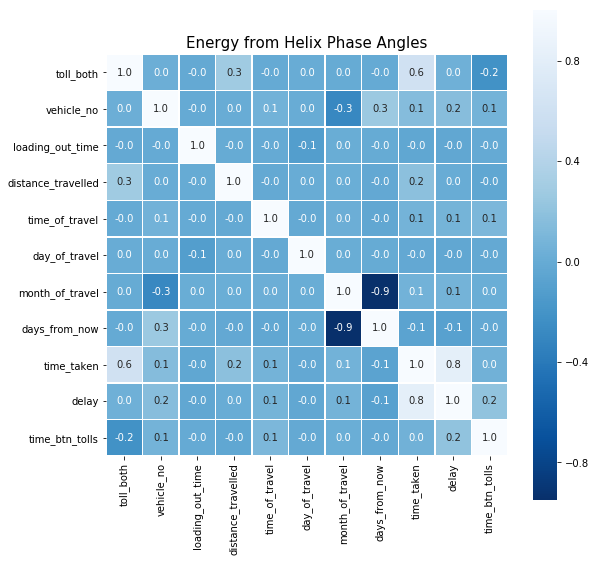

In [50]:
# seaborn heatmap documentation
# https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.heatmap.html

# cmap choices: http://matplotlib.org/users/colormaps.html
plt.figure(figsize=(9,9))
# pivot_table = phase_1_2.pivot('helix1 phase', 'helix 2 phase','Energy')
plt.xlabel('helix 2 phase', size = 15)
plt.ylabel('helix1 phase', size = 15)
plt.title('Energy from Helix Phase Angles', size = 15)
sns.heatmap(train_df.corr(), annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Blues_r');

In [51]:
train_df.drop(['time_taken'], axis=1, inplace=True)
test_df.drop(['time_taken'], axis=1, inplace=True)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [63]:
# train_df = train_df_copy
train_df.drop(['delay'], axis=1, inplace=True)

In [64]:
test_df.drop(['delay'], axis=1, inplace=True)

In [66]:
train_X = train_df.drop(['time_btn_tolls'], axis=1)
train_Y = train_df['time_btn_tolls']

In [53]:
# final_train_df = train_df[['toll_both','vehicle_no','loading_out_time','distance_travelled','time_btn_tolls']]

In [55]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [67]:
train_X

,toll_both,vehicle_no,loading_out_time,ist_timestamp,distance_travelled,distance_travelled_cummulative,time_of_travel,day_of_travel,month_of_travel,days_from_now,delivery,time_taken
471,Sergrarh,JH01AE6027,0,2017-11-09 13:57:40,0.00,0.00,13,2,11,49,1,85.678333
830,Manguli,JH01AE6027,0,2017-11-09 20:35:40,146.47,146.47,20,2,11,49,1,92.311667
292,Gudipada (Old Gangapada),JH01AE6027,0,2017-11-09 22:47:12,55.83,202.30,22,2,11,49,1,94.503889
2082,Bellupada,JH01AE6027,0,2017-11-10 06:52:59,171.77,374.07,6,2,11,49,1,102.600278
2247,Madapam,JH01AE6027,0,2017-11-10 13:30:33,114.17,488.24,13,2,11,49,1,109.226389
1388,Chilakapalem,JH01AE6027,0,2017-11-10 14:09:56,27.46,515.70,14,2,11,49,1,109.882778
2433,Nathavalasa/ Vizianagaram,JH01AE6027,0,2017-11-10 19:49:56,38.72,554.42,19,2,11,49,1,115.549444
1570,Vempadu,JH01AE6027,0,2017-11-11 11:01:14,67.28,691.69,11,2,11,49,1,130.737778
1009,Krishnavaram,JH01AE6027,0,2017-11-11 16:18:20,69.42,761.11,16,2,11,49,1,136.022778
1739,Kaza,JH01AE6027,0,2017-11-11 23:39:01,209.57,970.68,23,2,11,49,1,143.367500


In [57]:
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(train_X, train_Y)
# summarize scores
numpy.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(train_X)
# summarize selected features
print(features[0:5,:])

ValueError: Input X must be non-negative.

In [23]:
from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
import time

measurements = np.asarray([(399,293),(403,299),(409,308),(416,315),(418,318),(420,323),(429,326),(423,328),(429,334),(431,337),(433,342),(434,352),(434,349),(433,350),(431,350),(430,349),(428,347),(427,345),(425,341),(429,338),(431,328),(410,313),(406,306),(402,299),(397,291),(391,294),(376,270),(372,272),(351,248),(336,244),(327,236),(307,220)])

initial_state_mean = [measurements[0, 0],
                      0,
                      measurements[0, 1],
                      0]

In [27]:
measurements[0, 0], measurements[0, 1]

(399, 293)

In [28]:
transition_matrix = [[1, 1, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 1]]

In [29]:
observation_matrix = [[1, 0, 0, 0],
                      [0, 0, 1, 0]]

In [30]:
kf1 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean)

In [31]:
kf1 = kf1.em(measurements, n_iter=5)


In [32]:
(smoothed_state_means, smoothed_state_covariances) = kf1.smooth(measurements)

In [35]:
smoothed_state_covariances

array([[[ 0.26065393, -0.09936584,  0.06114406, -0.02496464],
        [-0.09936584,  0.20875724, -0.01190864,  0.05889393],
        [ 0.06114406, -0.01190864,  0.28344543, -0.1006541 ],
        [-0.02496464,  0.05889393, -0.1006541 ,  0.21738348]],

       [[ 2.18871193, -0.8409668 ,  1.27697294, -0.7557523 ],
        [-0.8409668 ,  1.44384451, -0.29419754,  0.86782628],
        [ 1.27697294, -0.29419754,  2.30883102, -0.73438632],
        [-0.7557523 ,  0.86782628, -0.73438632,  1.42816046]],

       [[ 2.88045273, -0.83834512,  1.78572729, -0.74353917],
        [-0.83834512,  1.61859334, -0.32545565,  0.9781369 ],
        [ 1.78572729, -0.32545565,  3.15954968, -0.75282412],
        [-0.74353917,  0.9781369 , -0.75282412,  1.64317448]],

       [[ 3.26887359, -0.86897466,  2.08818066, -0.73591162],
        [-0.86897466,  1.64816092, -0.38560479,  0.99486762],
        [ 2.08818066, -0.38560479,  3.61977788, -0.78012963],
        [-0.73591162,  0.99486762, -0.78012963,  1.68325476]],



In [36]:
plt.figure(1)

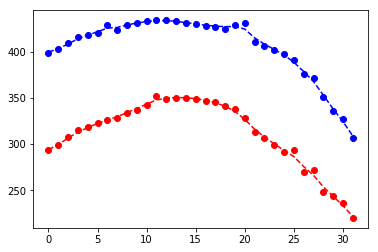

In [45]:
times = range(measurements.shape[0])
plt.plot(times, measurements[:, 0], 'bo',
         times, measurements[:, 1], 'ro',
         times, smoothed_state_means[:, 0], 'b--',
         times, smoothed_state_means[:, 2], 'r--',)
plt.show()

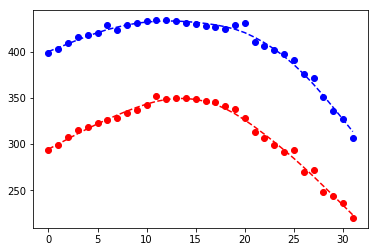

In [46]:
kf2 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean,
                  observation_covariance = 10*kf1.observation_covariance,
                  em_vars=['transition_covariance', 'initial_state_covariance'])

kf2 = kf2.em(measurements, n_iter=5)
(smoothed_state_means, smoothed_state_covariances)  = kf2.smooth(measurements)

plt.figure(2)
times = range(measurements.shape[0])
plt.plot(times, measurements[:, 0], 'bo',
         times, measurements[:, 1], 'ro',
         times, smoothed_state_means[:, 0], 'b--',
         times, smoothed_state_means[:, 2], 'r--',)
plt.show()

In [47]:
time_before = time.time()
n_real_time = 3

kf3 = KalmanFilter(transition_matrices = transition_matrix,
                  observation_matrices = observation_matrix,
                  initial_state_mean = initial_state_mean,
                  observation_covariance = 10*kf1.observation_covariance,
                  em_vars=['transition_covariance', 'initial_state_covariance'])

kf3 = kf3.em(measurements[:-n_real_time, :], n_iter=5)
(filtered_state_means, filtered_state_covariances) = kf3.filter(measurements[:-n_real_time,:])

print("Time to build and train kf3: %s seconds" % (time.time() - time_before))


Time to build and train kf3: 0.0992329120636 seconds


In [52]:
x_now = filtered_state_means[-1, :]
P_now = filtered_state_covariances[-1, :]
x_new = np.zeros((n_real_time, filtered_state_means.shape[1]))
i = 0

In [58]:
print x_now
print 
print P_now

[ 360.53714206   -8.81116353  256.07489811   -9.64787893]

[[ 34.9272319    8.92760763  24.98261589   6.63105915]
 [  8.92760763   6.41629219   6.72655924   4.79508602]
 [ 24.98261589   6.72655924  46.06916651  12.22617466]
 [  6.63105915   4.79508602  12.22617466   9.01679848]]


In [56]:
x_new

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [59]:
for measurement in measurements[-n_real_time:, :]:
    time_before = time.time()
    (x_now, P_now) = kf3.filter_update(filtered_state_mean = x_now,
                                       filtered_state_covariance = P_now,
                                       observation = measurement)
    print("Time to update kf3: %s seconds" % (time.time() - time_before))
    x_new[i, :] = x_now
    i = i + 1

Time to update kf3: 0.00128507614136 seconds
Time to update kf3: 0.00127100944519 seconds
Time to update kf3: 0.00105094909668 seconds


In [60]:
x_new

array([[ 345.14594166,  -10.44742844,  245.49568563,   -9.89532393],
       [ 331.4802771 ,  -11.23942539,  235.8303206 ,   -9.83445035],
       [ 314.69326043,  -12.63957536,  223.50435594,  -10.49586087]])

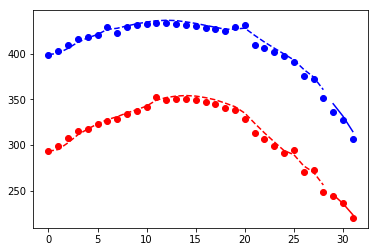

In [61]:
plt.figure(3)
old_times = range(measurements.shape[0] - n_real_time)
new_times = range(measurements.shape[0]-n_real_time, measurements.shape[0])
plt.plot(times, measurements[:, 0], 'bo',
         times, measurements[:, 1], 'ro',
         old_times, filtered_state_means[:, 0], 'b--',
         old_times, filtered_state_means[:, 2], 'r--',
         new_times, x_new[:, 0], 'b-',
         new_times, x_new[:, 2], 'r-')

plt.show()